In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/iciar/train/'
test_dir = "data/iciar/test/"

extracted_features_dir = "extracted_features/"
model_name = "iciar_DenseNet169"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/iciar/train/ 0
data/iciar/train/carcinoma 2310
data/iciar/train/non-carcinoma 2310
******************************
data/iciar/test/ 0
data/iciar/test/carcinoma 50
data/iciar/test/non-carcinoma 50


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 3466 images belonging to 2 classes.
Found 1154 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3466
nb_validation_samples: 1154

predict_size_train: 109
predict_size_validation: 37
nb_test_samples: 100
predict_size_test: 4

 num_classes: 2


In [9]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [10]:
# from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet


In [11]:
input_tensor = Input(shape = input_shape)  
model = DenseNet169(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [12]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [13]:
# c1 = model.layers[9].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[55].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[143].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[483].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c3, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [14]:
# bottleneck_final_model.summary()

In [15]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [16]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [17]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [18]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 3466 samples, validate on 1154 samples
Epoch 1/1000
 - 2s - loss: 0.5980 - acc: 0.6939 - val_loss: 0.4150 - val_acc: 0.8198
Epoch 2/1000
 - 0s - loss: 0.4221 - acc: 0.8113 - val_loss: 0.3383 - val_acc: 0.8596
Epoch 3/1000
 - 0s - loss: 0.3560 - acc: 0.8520 - val_loss: 0.2921 - val_acc: 0.8873
Epoch 4/1000
 - 0s - loss: 0.3036 - acc: 0.8751 - val_loss: 0.2569 - val_acc: 0.8908
Epoch 5/1000
 - 0s - loss: 0.2605 - acc: 0.8984 - val_loss: 0.2336 - val_acc: 0.9125
Epoch 6/1000
 - 0s - loss: 0.2301 - acc: 0.9103 - val_loss: 0.2088 - val_acc: 0.9185
Epoch 7/1000
 - 0s - loss: 0.2094 - acc: 0.9253 - val_loss: 0.2067 - val_acc: 0.9151
Epoch 8/1000
 - 0s - loss: 0.1867 - acc: 0.9359 - val_loss: 0.1746 - val_acc: 0.9324
Epoch 9/1000
 - 0s - loss: 0.1662 - acc: 0.9420 - val_loss: 0.1620 - val_acc: 0.9367
Epoch 10/1000
 - 0s - loss: 0.1531 - acc: 0.9535 - val_loss: 0.1497 - val_acc: 0.9437
Epoch 11/1000
 - 0s - loss: 0.1401 - acc: 0.9550 - val_loss: 0.1367 - val_acc: 0.9532
Epoch 12/1000
 

Epoch 95/1000
 - 0s - loss: 3.1931e-04 - acc: 1.0000 - val_loss: 0.0373 - val_acc: 0.9870
Epoch 96/1000
 - 0s - loss: 2.8560e-04 - acc: 1.0000 - val_loss: 0.0426 - val_acc: 0.9853
Epoch 97/1000
 - 0s - loss: 2.9952e-04 - acc: 1.0000 - val_loss: 0.0332 - val_acc: 0.9870
Epoch 98/1000
 - 0s - loss: 4.1957e-04 - acc: 1.0000 - val_loss: 0.0414 - val_acc: 0.9887
Epoch 99/1000
 - 0s - loss: 1.7397e-04 - acc: 1.0000 - val_loss: 0.0374 - val_acc: 0.9861
Epoch 100/1000
 - 0s - loss: 2.9557e-04 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9879
Epoch 101/1000
 - 0s - loss: 3.2158e-04 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9870
Epoch 102/1000
 - 0s - loss: 2.0232e-04 - acc: 1.0000 - val_loss: 0.0349 - val_acc: 0.9870
Epoch 103/1000
 - 0s - loss: 3.3785e-04 - acc: 1.0000 - val_loss: 0.0352 - val_acc: 0.9879
Epoch 104/1000
 - 0s - loss: 1.6423e-04 - acc: 1.0000 - val_loss: 0.0379 - val_acc: 0.9879
Epoch 105/1000
 - 0s - loss: 1.7335e-04 - acc: 1.0000 - val_loss: 0.0405 - val_acc: 0.9870
Epoc

 - 0s - loss: 6.1659e-06 - acc: 1.0000 - val_loss: 0.0389 - val_acc: 0.9887
Epoch 186/1000
 - 0s - loss: 3.9051e-06 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 0.9879
Epoch 187/1000
 - 0s - loss: 7.2039e-06 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 0.9879
Epoch 188/1000
 - 0s - loss: 1.1911e-05 - acc: 1.0000 - val_loss: 0.0470 - val_acc: 0.9870
Epoch 189/1000
 - 0s - loss: 2.4819e-06 - acc: 1.0000 - val_loss: 0.0454 - val_acc: 0.9879
Epoch 190/1000
 - 0s - loss: 1.6228e-05 - acc: 1.0000 - val_loss: 0.0449 - val_acc: 0.9861
Epoch 191/1000
 - 0s - loss: 3.0105e-06 - acc: 1.0000 - val_loss: 0.0600 - val_acc: 0.9861
Epoch 192/1000
 - 0s - loss: 2.3023e-06 - acc: 1.0000 - val_loss: 0.0542 - val_acc: 0.9870
Epoch 193/1000
 - 0s - loss: 3.3716e-06 - acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.9887
Epoch 194/1000
 - 0s - loss: 2.4734e-06 - acc: 1.0000 - val_loss: 0.0499 - val_acc: 0.9879
Epoch 195/1000
 - 0s - loss: 3.1188e-05 - acc: 1.0000 - val_loss: 0.0507 - val_acc: 0.9879
Epoch 196/1000

Epoch 276/1000
 - 0s - loss: 1.6262e-06 - acc: 1.0000 - val_loss: 0.0474 - val_acc: 0.9887
Epoch 277/1000
 - 0s - loss: 1.4031e-06 - acc: 1.0000 - val_loss: 0.0507 - val_acc: 0.9896
Epoch 278/1000
 - 0s - loss: 6.4500e-07 - acc: 1.0000 - val_loss: 0.0490 - val_acc: 0.9870
Epoch 279/1000
 - 0s - loss: 4.1267e-07 - acc: 1.0000 - val_loss: 0.0473 - val_acc: 0.9896
Epoch 280/1000
 - 0s - loss: 1.4111e-06 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 0.9887
Epoch 281/1000
 - 0s - loss: 5.3732e-07 - acc: 1.0000 - val_loss: 0.0475 - val_acc: 0.9879
Epoch 282/1000
 - 0s - loss: 9.2941e-07 - acc: 1.0000 - val_loss: 0.0480 - val_acc: 0.9887
Epoch 283/1000
 - 0s - loss: 1.0842e-06 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 0.9879
Epoch 284/1000
 - 0s - loss: 3.6159e-07 - acc: 1.0000 - val_loss: 0.0463 - val_acc: 0.9887
Epoch 285/1000
 - 0s - loss: 4.1484e-07 - acc: 1.0000 - val_loss: 0.0528 - val_acc: 0.9896
Epoch 286/1000
 - 0s - loss: 4.8626e-07 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 0.9879

 - 0s - loss: 2.6674e-07 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 0.9896
Epoch 367/1000
 - 0s - loss: 2.0618e-07 - acc: 1.0000 - val_loss: 0.0549 - val_acc: 0.9905
Epoch 368/1000
 - 0s - loss: 1.6138e-07 - acc: 1.0000 - val_loss: 0.0499 - val_acc: 0.9887
Epoch 369/1000
 - 0s - loss: 4.5053e-07 - acc: 1.0000 - val_loss: 0.0493 - val_acc: 0.9905
Epoch 370/1000
 - 0s - loss: 1.8033e-06 - acc: 1.0000 - val_loss: 0.0474 - val_acc: 0.9887
Epoch 371/1000
 - 0s - loss: 2.5982e-07 - acc: 1.0000 - val_loss: 0.0460 - val_acc: 0.9905
Epoch 372/1000
 - 0s - loss: 1.8716e-07 - acc: 1.0000 - val_loss: 0.0489 - val_acc: 0.9896
Epoch 373/1000
 - 0s - loss: 1.8554e-07 - acc: 1.0000 - val_loss: 0.0474 - val_acc: 0.9879
Epoch 374/1000
 - 0s - loss: 2.1915e-07 - acc: 1.0000 - val_loss: 0.0531 - val_acc: 0.9887
Epoch 375/1000
 - 0s - loss: 4.4328e-07 - acc: 1.0000 - val_loss: 0.0529 - val_acc: 0.9896
Epoch 376/1000
 - 0s - loss: 1.7128e-07 - acc: 1.0000 - val_loss: 0.0490 - val_acc: 0.9887
Epoch 377/1000

Epoch 457/1000
 - 0s - loss: 2.3803e-07 - acc: 1.0000 - val_loss: 0.0543 - val_acc: 0.9887
Epoch 458/1000
 - 0s - loss: 1.4987e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9879
Epoch 459/1000
 - 0s - loss: 1.1967e-06 - acc: 1.0000 - val_loss: 0.0461 - val_acc: 0.9913
Epoch 460/1000
 - 0s - loss: 1.3166e-07 - acc: 1.0000 - val_loss: 0.0441 - val_acc: 0.9905
Epoch 461/1000
 - 0s - loss: 2.4852e-07 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9905
Epoch 462/1000
 - 0s - loss: 1.3448e-07 - acc: 1.0000 - val_loss: 0.0483 - val_acc: 0.9896
Epoch 463/1000
 - 0s - loss: 1.2862e-07 - acc: 1.0000 - val_loss: 0.0464 - val_acc: 0.9887
Epoch 464/1000
 - 0s - loss: 1.4740e-07 - acc: 1.0000 - val_loss: 0.0462 - val_acc: 0.9905
Epoch 465/1000
 - 0s - loss: 1.6196e-07 - acc: 1.0000 - val_loss: 0.0498 - val_acc: 0.9896
Epoch 466/1000
 - 0s - loss: 2.1487e-07 - acc: 1.0000 - val_loss: 0.0468 - val_acc: 0.9870
Epoch 467/1000
 - 0s - loss: 2.0804e-07 - acc: 1.0000 - val_loss: 0.0506 - val_acc: 0.9913

 - 0s - loss: 1.3056e-07 - acc: 1.0000 - val_loss: 0.0466 - val_acc: 0.9905
Epoch 548/1000
 - 0s - loss: 1.3047e-07 - acc: 1.0000 - val_loss: 0.0470 - val_acc: 0.9879
Epoch 549/1000
 - 0s - loss: 4.6333e-07 - acc: 1.0000 - val_loss: 0.0520 - val_acc: 0.9870
Epoch 550/1000
 - 0s - loss: 3.2807e-07 - acc: 1.0000 - val_loss: 0.0530 - val_acc: 0.9887
Epoch 551/1000
 - 0s - loss: 1.3758e-07 - acc: 1.0000 - val_loss: 0.0454 - val_acc: 0.9905
Epoch 552/1000
 - 0s - loss: 1.6096e-07 - acc: 1.0000 - val_loss: 0.0490 - val_acc: 0.9896
Epoch 553/1000
 - 0s - loss: 1.2566e-07 - acc: 1.0000 - val_loss: 0.0489 - val_acc: 0.9879
Epoch 554/1000
 - 0s - loss: 2.0465e-07 - acc: 1.0000 - val_loss: 0.0432 - val_acc: 0.9896
Epoch 555/1000
 - 0s - loss: 1.2578e-07 - acc: 1.0000 - val_loss: 0.0450 - val_acc: 0.9870
Epoch 556/1000
 - 0s - loss: 2.9296e-07 - acc: 1.0000 - val_loss: 0.0452 - val_acc: 0.9905
Epoch 557/1000
 - 0s - loss: 1.6306e-07 - acc: 1.0000 - val_loss: 0.0446 - val_acc: 0.9887
Epoch 558/1000

Epoch 638/1000
 - 0s - loss: 1.3025e-07 - acc: 1.0000 - val_loss: 0.0497 - val_acc: 0.9879
Epoch 639/1000
 - 0s - loss: 1.3336e-07 - acc: 1.0000 - val_loss: 0.0472 - val_acc: 0.9887
Epoch 640/1000
 - 0s - loss: 1.2858e-07 - acc: 1.0000 - val_loss: 0.0478 - val_acc: 0.9879
Epoch 641/1000
 - 0s - loss: 1.5966e-07 - acc: 1.0000 - val_loss: 0.0492 - val_acc: 0.9887
Epoch 642/1000
 - 0s - loss: 1.2905e-07 - acc: 1.0000 - val_loss: 0.0466 - val_acc: 0.9887
Epoch 643/1000
 - 0s - loss: 1.2507e-07 - acc: 1.0000 - val_loss: 0.0488 - val_acc: 0.9896
Epoch 644/1000
 - 0s - loss: 1.2418e-07 - acc: 1.0000 - val_loss: 0.0500 - val_acc: 0.9879
Epoch 645/1000
 - 0s - loss: 1.2151e-07 - acc: 1.0000 - val_loss: 0.0473 - val_acc: 0.9896
Epoch 646/1000
 - 0s - loss: 1.3023e-07 - acc: 1.0000 - val_loss: 0.0466 - val_acc: 0.9896
Epoch 647/1000
 - 0s - loss: 1.2777e-07 - acc: 1.0000 - val_loss: 0.0470 - val_acc: 0.9887
Epoch 648/1000
 - 0s - loss: 1.4576e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9879

 - 0s - loss: 1.2985e-07 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 0.9879
Epoch 729/1000
 - 0s - loss: 1.3034e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9887
Epoch 730/1000
 - 0s - loss: 1.3040e-07 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 0.9905
Epoch 731/1000
 - 0s - loss: 1.2745e-07 - acc: 1.0000 - val_loss: 0.0521 - val_acc: 0.9879
Epoch 732/1000
 - 0s - loss: 1.2081e-07 - acc: 1.0000 - val_loss: 0.0500 - val_acc: 0.9896
Epoch 733/1000
 - 0s - loss: 1.9227e-07 - acc: 1.0000 - val_loss: 0.0679 - val_acc: 0.9896
Epoch 734/1000
 - 0s - loss: 2.0849e-07 - acc: 1.0000 - val_loss: 0.0467 - val_acc: 0.9913
Epoch 735/1000
 - 0s - loss: 1.2996e-07 - acc: 1.0000 - val_loss: 0.0484 - val_acc: 0.9896
Epoch 736/1000
 - 0s - loss: 1.3027e-07 - acc: 1.0000 - val_loss: 0.0518 - val_acc: 0.9879
Epoch 737/1000
 - 0s - loss: 1.3070e-07 - acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.9887
Epoch 738/1000
 - 0s - loss: 1.9894e-07 - acc: 1.0000 - val_loss: 0.0494 - val_acc: 0.9879
Epoch 739/1000

Epoch 819/1000
 - 0s - loss: 1.2641e-07 - acc: 1.0000 - val_loss: 0.0475 - val_acc: 0.9896
Epoch 820/1000
 - 0s - loss: 1.2175e-07 - acc: 1.0000 - val_loss: 0.0475 - val_acc: 0.9887
Epoch 821/1000
 - 0s - loss: 1.2248e-07 - acc: 1.0000 - val_loss: 0.0485 - val_acc: 0.9896
Epoch 822/1000
 - 0s - loss: 1.2709e-07 - acc: 1.0000 - val_loss: 0.0498 - val_acc: 0.9887
Epoch 823/1000
 - 0s - loss: 1.6172e-07 - acc: 1.0000 - val_loss: 0.0490 - val_acc: 0.9879
Epoch 824/1000
 - 0s - loss: 1.3090e-07 - acc: 1.0000 - val_loss: 0.0512 - val_acc: 0.9896
Epoch 825/1000
 - 0s - loss: 1.3040e-07 - acc: 1.0000 - val_loss: 0.0518 - val_acc: 0.9887
Epoch 826/1000
 - 0s - loss: 1.5742e-07 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 0.9887
Epoch 827/1000
 - 0s - loss: 1.9033e-07 - acc: 1.0000 - val_loss: 0.0474 - val_acc: 0.9905
Epoch 828/1000
 - 0s - loss: 1.2427e-07 - acc: 1.0000 - val_loss: 0.0485 - val_acc: 0.9905
Epoch 829/1000
 - 0s - loss: 1.3095e-07 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 0.9896

 - 0s - loss: 1.2509e-07 - acc: 1.0000 - val_loss: 0.0470 - val_acc: 0.9896
Epoch 910/1000
 - 0s - loss: 1.2402e-07 - acc: 1.0000 - val_loss: 0.0466 - val_acc: 0.9887
Epoch 911/1000
 - 0s - loss: 1.3068e-07 - acc: 1.0000 - val_loss: 0.0463 - val_acc: 0.9905
Epoch 912/1000
 - 0s - loss: 1.2287e-07 - acc: 1.0000 - val_loss: 0.0473 - val_acc: 0.9887
Epoch 913/1000
 - 0s - loss: 1.2108e-07 - acc: 1.0000 - val_loss: 0.0470 - val_acc: 0.9905
Epoch 914/1000
 - 0s - loss: 1.2394e-07 - acc: 1.0000 - val_loss: 0.0476 - val_acc: 0.9887
Epoch 915/1000
 - 0s - loss: 1.3360e-07 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 0.9896
Epoch 916/1000
 - 0s - loss: 1.2024e-07 - acc: 1.0000 - val_loss: 0.0497 - val_acc: 0.9896
Epoch 917/1000
 - 0s - loss: 1.4458e-07 - acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.9879
Epoch 918/1000
 - 0s - loss: 1.2212e-07 - acc: 1.0000 - val_loss: 0.0475 - val_acc: 0.9887
Epoch 919/1000
 - 0s - loss: 1.2200e-07 - acc: 1.0000 - val_loss: 0.0512 - val_acc: 0.9896
Epoch 920/1000

Epoch 1000/1000
 - 0s - loss: 1.2198e-07 - acc: 1.0000 - val_loss: 0.0491 - val_acc: 0.9896


In [19]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.92


Confusion Matrix
[[48  2]
 [ 6 44]]


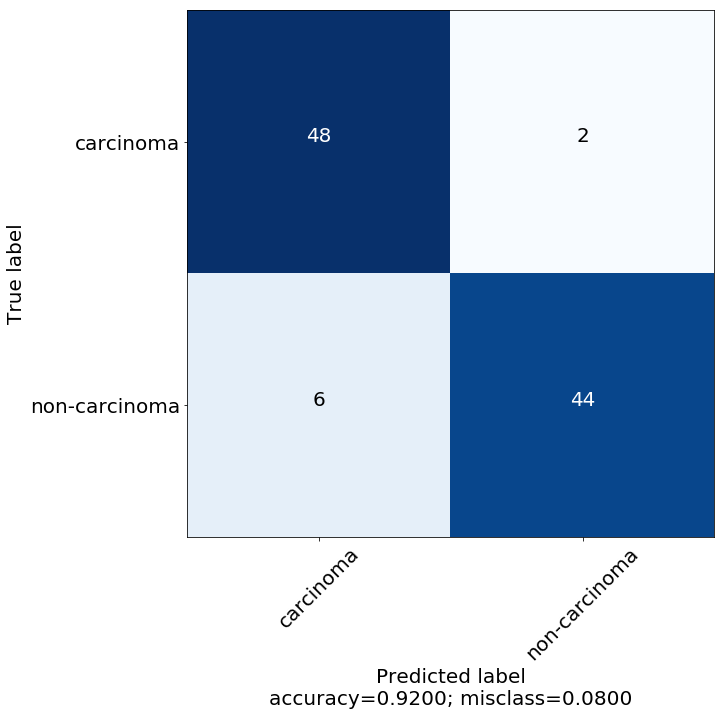

In [20]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[48  2]
 [ 6 44]]
               precision    recall  f1-score   support

    carcinoma       0.89      0.96      0.92        50
non-carcinoma       0.96      0.88      0.92        50

  avg / total       0.92      0.92      0.92       100



In [22]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  88.88888888888889
Specificity :  95.65217391304348


In [23]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.9227053140096618


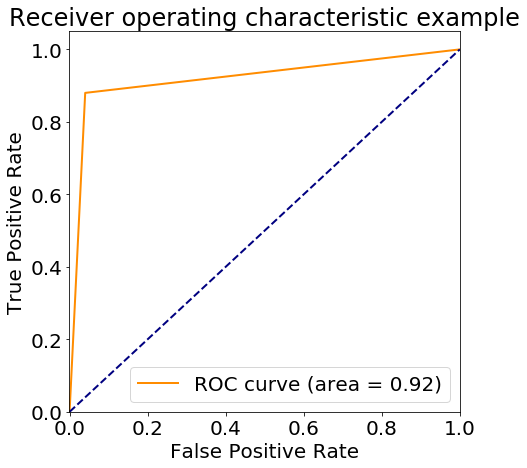

In [24]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [25]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

100/100 [==============================] - 0s 70us/step


In [26]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [27]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

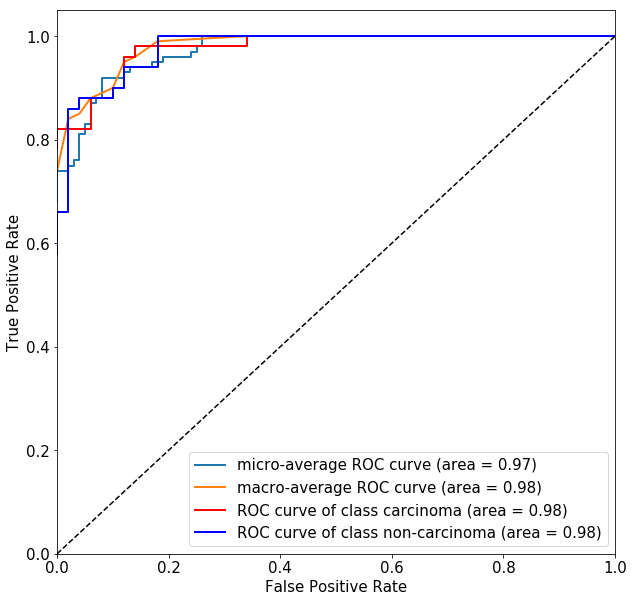

In [28]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [29]:
tn, fp, fn, tp = cm.ravel()

In [30]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.92
Precision: 0.9565217391304348
Recall: 0.88
tp: 44
fp: 2
tn: 48
fn: 6


In [31]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.9166666666666666


In [32]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.9166666666666667


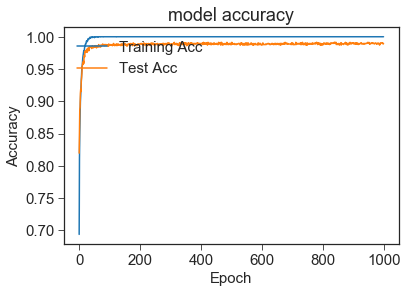

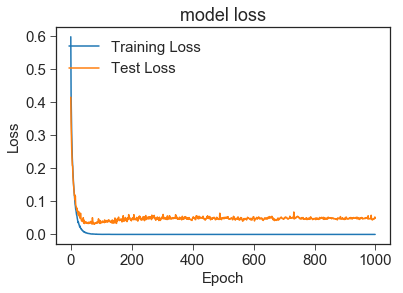

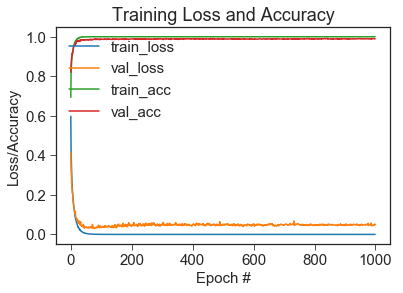

In [33]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")